In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame

In [2]:
conf = (SparkConf()
            .setAppName('data_explore')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

# TODO

+ test final model against this dataset: https://github.com/hunters-forge/mordor
+ see if writing model (model.save) with partitionBy param helps
---


In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.default.parallelism', '6'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.app.id', 'app-20191109202115-0004'),
 ('spark.driver.memory', '3g'),
 ('spark.driver.port', '40449'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'data_explore')]

In [5]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() # orginal dataset had 52,025 rows, this operation drops 682 rows
     )
df.cache()

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

# Data Cleaning and Engineering

---


## the target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

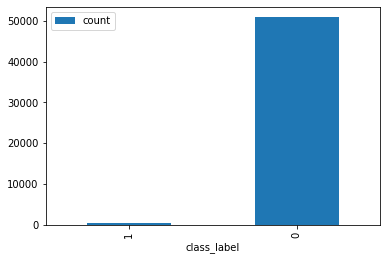

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.count()

51343

In [ ]:
bootstrapped_1_rdd = [df.filter('class_label == 1').sample(withReplacement=True, fraction=.1, seed=0).rdd for x in range(1000)]
_rdds = spark.sparkContext.union(bootstrapped_1_rdd)
bootstrapped_1_df = spark.createDataFrame(_rdds)
bootstrapped_1_df.cache()  # doesn't seem to speed up process; is spark clearing memory?

In [10]:
combined_df = spark.createDataFrame(spark.sparkContext.union([df.rdd, bootstrapped_1_df.rdd]))

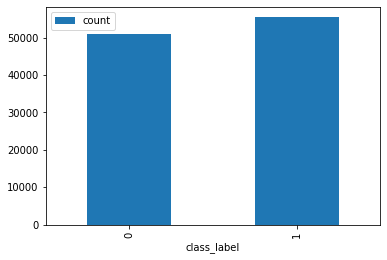

In [11]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [12]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [113]:
# load resampled df and cache
resampled_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
resampled_df.cache()

DataFrame[timestamp: timestamp, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

### Clean process,path fields and create command line tokens

In [114]:
# TODO: consider converting this to a UDF

from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date
resampled_df = resampled_df.select(
    '*',
    regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    split(col('command_line'), '\s+(?=[-/]+)').alias('cmd_line_split')
).withColumn(
    'class_label', (col('class_label').cast('int'))
).withColumn(
    'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like('%Program Files (x86)%')).cast('int')
).withColumn(
    '_timestamp', F.to_timestamp(col('timestamp'))
).withColumn(
    'process_name', regexp_extract(col('process_name'), r'(\w+.?\w+$)', 0)
).withColumn(
    'parent_process', regexp_extract(col('parent_process'), r'(\w+.?\w+$)', 0)
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[:\\"\?]'," ")  # directory punct
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'--field-trial-handle=.*\d+',"")   # chrome data
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\/\/raw.*\.com(\/\w+)*.*\/',"") # github url
).withColumn(
    'command_line', regexp_replace(col('command_line'), r"\||\s*\"\s*\|\"|-\s*\d{1}\s*|\'","")  # | " 1 ' , 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r':\/\/(\d+\.?)+:\d+',"")  # ip 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\b\d+\b',"")  # lone numbers
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\{.*\}',"")  # {edfc6dbe, 9c3, 3ed, 21a1affb5fd}
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[=/;\(\),_]',"") # random punctuation
).withColumn(
    'cmd_line_tokens', split(col('command_line'), '\s+')
)

### Cleaned command line tokens

In [115]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def clean_array(l):
    arr = [str(x).lower() for x in l if x != 'C' and x != ""]
    return arr

In [116]:
resampled_df = resampled_df.withColumn('cmd_line_tokens', clean_array(col('cmd_line_tokens')))

In [118]:
resampled_df.select('cmd_line_tokens').sample(.10).show(5, False)

+-------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                      |
+-------------------------------------------------------------------------------------+
|[windows, system32, svchost.exe, -k, localservice, -p, -s, dispbrokerdesktopsvc]     |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p, -s, eventlog]|
|[windows, servicing, trustedinstaller.exe]                                           |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p, -s, dhcp]    |
|[windows, system32, svchost.exe, -k, networkservice, -p, -s, nlasvc]                 |
+-------------------------------------------------------------------------------------+
only showing top 5 rows



### Create train, validation, test split

In [166]:
training_df, validation_df, testing_df = resampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [167]:
[training_df.count(), validation_df.count(), testing_df.count()]

[63801, 31852, 10690]

### Create freq and tfidf pipeline and fit to training data

In [168]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(training_df)

In [169]:
cv_pipeline.transform(resampled_df).select('tf').show(5,truncate=False)

+------------------------------------------------------------------------+
|tf                                                                      |
+------------------------------------------------------------------------+
|(1109,[11,12,100,101,128,309],[1.0,1.0,1.0,1.0,1.0,1.0])                |
|(1109,[11,12,100,101,128,129,196,517],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(1109,[568,1033],[1.0,1.0])                                             |
|(1109,[11,12,568,800],[1.0,1.0,1.0,1.0])                                |
|(1109,[11,12,100,101,128,129,192,489],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+------------------------------------------------------------------------+
only showing top 5 rows



In [170]:
len(cv_pipeline.stages[0].vocabulary)

1109

In [187]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(training_df)

# Modeling
---

### create logistic regression model

In [191]:
lr = LogisticRegression(featuresCol='tfidf', labelCol='class_label')

In [192]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    lr
]).fit(training_df)

In [193]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [194]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.999905814391561|
+-----------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [195]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

In [196]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
14,cmd.exe,19.442095
3,-c,4.422955
2,powershell.exe,4.334876
4,bypass,4.266387
5,-executionpolicy,4.266387
475,scrobj.dll,2.967283
485,i,2.967283
486,u,2.967283
491,regsvr32.sct,2.967283
136,get-nettcpconnection,2.695755


### Example of malicious tokens

In [198]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_split').show(5, truncate=False)

+--------------------------------------------------------------------------------------+
|cmd_line_split                                                                        |
+--------------------------------------------------------------------------------------+
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
+--------------------------------------------------------------------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [199]:
coeffs_df.sort_values('weight').head(20)

,token,weight
12,system32,-14.358118
11,windows,-13.004495
178,taskhostw.exe,-3.187900
631,wmiadap.exe,-2.747591
252,consent.exe,-2.508383
304,fontdrvhost.exe,-2.319579
397,dwm.exe,-2.203038
493,sihost.exe,-2.127204
529,ctfmon.exe,-2.091393
366,background,-2.086209


### Example of benign tokens

In [201]:
training_df.filter('class_label == 0').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------+
|[windows, winsxs, amd64microsoft-windows-servicingstack31bf3856ad364e3510...411none5f53d2d858cf8961, tiworker.exe, -embedding]|
|[windows, system32, svchost.exe, -k, swprv]                                                                                   |
|[windows, system32, searchindexer.exe, embedding]                                                                             |
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.windowsmaps8wekyb3d8bbwe]                     |
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.windowssoundreco

### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [211]:
en_lr_estimator = Pipeline(stages=[
    idf_pipeline,
    LogisticRegression(featuresCol='tfidf',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_pipeline = en_lr_estimator.fit(training_df)

### Re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [212]:
coefs = en_lr.stages[-1].coefficients.toArray()
word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weights': coefs})

+ malicious tokens

In [237]:
word_coefs.sort_values('weights', ascending=False).head(20)

,token,weights
14,cmd.exe,1.317535
4,bypass,1.173568
5,-executionpolicy,1.173568
3,-c,1.130623
2,powershell.exe,0.885644
52,whoami,0.453677
23,arp,0.387180
22,-a,0.350790
49,net,0.292329
48,share,0.260128


+ benign tokens

In [238]:
word_coefs.sort_values('weights', ascending=True).head(20)

,token,weights
11,windows,-0.641115
6,program,-0.517428
7,files,-0.515940
8,x86,-0.446950
9,application,-0.413915
10,chrome.exe,-0.413226
12,system32,-0.403662
178,taskhostw.exe,-0.217318
71,-embedding,-0.161987
113,microsoft.net,-0.097604


# Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [206]:
en_lr.stages

[PipelineModel_40713b69237c,
 LogisticRegressionModel: uid = LogisticRegression_42b2cafaa886, numClasses = 2, numFeatures = 1109]

In [207]:
en_lr_val = LogisticRegression()

In [225]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr.stages[1].regParam, [0., 0.01, 0.02]) 
                 .addGrid(en_lr.stages[1].elasticNetParam, [0., 0.2, 0.4]) 
                 .build()
            )
paramGrid

[{Param(parent='LogisticRegression_42b2cafaa886', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_42b2cafaa886', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0},
 {Param(parent='LogisticRegression_42b2cafaa886', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_42b2cafaa886', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.2},
 {Param(parent='LogisticRegression_42b2cafaa886', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_42b2cafaa886', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.4},
 {Param(pa

+ Loop over each parameter mapping in paramGrid and fit model

In [216]:
models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_estimator.fit(validation_df, paramGrid[g])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the accuracy of each model

In [220]:
accuracies = [m.\
    transform(validation_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in models]

In [221]:
accuracies

[0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186,
 0.9988383774959186]

# Cross validation 
+ test generalization performance on test dataset

---

In [233]:
import numpy as np
best_model_idx = np.argmax(accuracies)
best_model = models[best_model_idx]
accuracies[best_model_idx]

0.9988383774959186

In [234]:
paramGrid[best_model_idx]

{Param(parent='LogisticRegression_42b2cafaa886', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LogisticRegression_42b2cafaa886', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [236]:
best_model.\
    transform(testing_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    show()

+------------------+
|          accuracy|
+------------------+
|0.9986903648269411|
+------------------+



### Write LR intecept, coefficients, and CV vocabulary to disk

In [ ]:
en_lr.stages[1].intercept

In [ ]:
import pickle

with open('coefs_array.pkl', 'wb') as f:
    pickle.dump(coefs, f)
with open('intercept.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[1].intercept, f)
with open('cv_vocabulary.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[0].stages[0].stages[0].vocabulary, f)